# 3.3 线性回归的简洁实现

随着深度学习框架的发展，开发深度学习应用变得越来越便利。实践中，我们通常可以用比上一节更简洁的代码来实现同样的模型。在本节中，我们将介绍如何使用tensorflow2.0推荐的keras接口更方便地实现线性回归的训练。




整体框架
---
- 3.3.1 生成数据集 

$ labels_{(m,1)} = Xw^T + b +噪声矩阵$

- 3.3.2 读取数据

from tensorflow import data as tfdata
- 3.3.3 定义模型和初始化参数

from tensorflow import keras

from tensorflow.keras import layers

from tensorflow import initializers as init
- 3.3.4 定义损失函数

from tensorflow import losses
- 3.3.5 定义优化算法

from tensorflow.keras import optimizers
- 3.3.6 训练模型

In [152]:
import tensorflow as tf


3.3.1 生成数据集
---

features是训练数据特征，labels是标签

$如下：labels = Xw^T + b +噪声矩阵 ，labels 尺寸为(m,1)$

In [153]:
num_inputs = 2
num_examples = 1000
true_w = tf.constant(value=[2, -3.4],shape=(1,2))
true_b = 4.2
features = tf.random.normal(shape=(num_examples,num_inputs),stddev=1)
labels = tf.matmul(a=features,b=tf.constant(true_w),transpose_b=True) + true_b
labels += tf.random.normal(shape=labels.shape,stddev=0.01)

3.3.2 读取数据
---

In [154]:
from tensorflow import data as tfdata

In [155]:
# 训练数据的特征和标签组合
dataset = tfdata.Dataset.from_tensor_slices((features,labels))

In [156]:
# 随机小批量
dataset = dataset.shuffle(buffer_size=num_examples)
dataset = dataset.batch(batch_size=10)

    # shuffle 的 buffer_size 参数应大于等于样本数。
    # batch 可以指定 batch_size 的分割大小。

In [157]:
# 测试
for (batch, (X, y)) in enumerate(dataset):
    print(X, y)
    break
    
    # 或者 for (X, y) in iter(dataset): 

tf.Tensor(
[[ 0.7563913  -0.725039  ]
 [ 0.6650467   0.23587158]
 [-0.02802405 -0.08670424]
 [ 0.73939914  1.3308651 ]
 [ 0.07667072 -1.0927807 ]
 [-0.0946912  -0.25699905]
 [-0.9505184  -1.2769258 ]
 [-1.5663085  -2.699292  ]
 [ 1.0455514   0.9739247 ]
 [-0.3476572   0.40290084]], shape=(10, 2), dtype=float32) tf.Tensor(
[[ 8.193167 ]
 [ 4.7414517]
 [ 4.4327374]
 [ 1.1615415]
 [ 8.065019 ]
 [ 4.8700824]
 [ 6.6242805]
 [10.239409 ]
 [ 2.98605  ]
 [ 2.1438503]], shape=(10, 1), dtype=float32)


3.3.3 定义模型和初始化参数
---

Tensorflow 2.0推荐使用Keras定义网络，故使用Keras定义网络 我们先定义一个模型变量model，它是一个Sequential实例。 在Keras中，Sequential实例可以看作是一个串联各个层的容器。

在构造模型时，我们在该容器中依次添加层。 当给定输入数据时，容器中的每一层将依次推断下一层的输入尺寸。 重要的一点是，在Keras中我们无须指定每一层输入的形状。 线性回归，输入层与输出层等效为一层全连接层keras.layers.Dense()。


Keras 中初始化参数由 kernel_initializer 和 bias_initializer 选项分别设置权重和偏置的初始化方式

RandomNormal(stddev=0.01)指定权重参数每个元素将在初始化时随机采样于均值为0、标准差为0.01的正态分布。偏差参数默认会初始化为零。

In [158]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow import initializers as init

model = keras.Sequential()
model.add(layer=layers.Dense(1,kernel_initializer=init.RandomNormal(stddev=0.01)))

3.3.4 定义损失函数
---

In [159]:
from tensorflow import losses
loss = losses.MeanSquaredError()
    # 均方损失

3.3.5 定义优化算法
---
承担了更新权重

In [160]:
from tensorflow.keras import optimizers
trainer = optimizers.SGD(learning_rate=0.03)

3.3.6 训练模型
---
在使用Tensorflow训练模型时，我们通过调用tensorflow.GradientTape记录动态图梯度，执行tape.gradient获得动态图中各变量梯度。通过 model.trainable_variables 找到需要更新的变量，并用 trainer.apply_gradients 更新权重，完成一步训练。

In [161]:
num_epochs = 3
for epoch in range(1,num_epochs+1):
    for (batch,(X,y)) in enumerate(dataset):
        with tf.GradientTape() as tape:
            l = loss(y_true=y,y_pred=model(X,training=True))
            
        grads = tape.gradient(target=l,sources=model.trainable_variables)
        trainer.apply_gradients(grads_and_vars=zip(grads,model.trainable_variables))
        
    l = loss(y_true=labels,y_pred=model(features))
    print('epoch %d,loss:%f' % (epoch,l))

epoch 1,loss:0.000205
epoch 2,loss:0.000099
epoch 3,loss:0.000099


比较
---

In [168]:
import numpy as np

In [173]:
np.array(true_w),np.array(model.get_weights()[0])

(array([[ 2. , -3.4]], dtype=float32),
 array([[ 1.9998105],
        [-3.3991916]], dtype=float32))

In [174]:
np.array(true_b),np.array(model.get_weights()[1])

(array(4.2), array([4.2003183], dtype=float32))

---
线性回归的拟合非常好
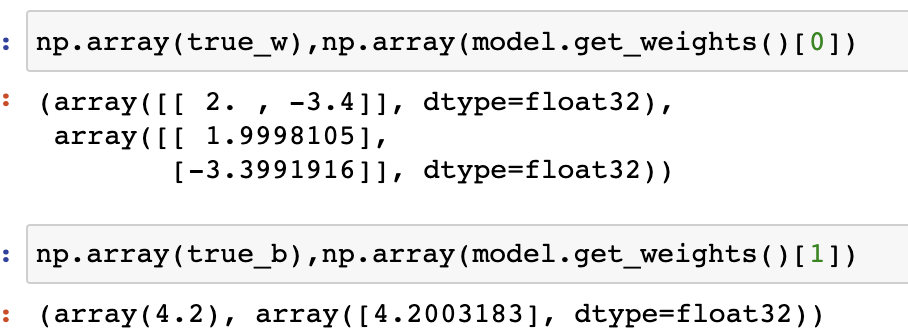